In [1]:
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
from ase import *
from ase.io import read
from gpaw import *
from gpaw.lcao.pwf2 import LCAOwrap
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from qtpyt.basis import Basis
from qtpyt.lo.tools import lowdin_rotation, rotate_matrix, subdiagonalize_atoms
from scipy.linalg import eigh


[anooja-ThinkPad-X1-Carbon-Gen-11:44620] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


In [18]:
def plot_hamiltonian_overlap(H, S, cmap, norm, title_H="H Matrix", title_S="S Matrix"):
    """
    Plot the Hamiltonian and Overlap matrices with a shared colorbar and customized color mapping.

    Parameters:
    - H: np.ndarray, Hamiltonian matrix to visualize.
    - S: np.ndarray, Overlap matrix to visualize.
    - cmap: Colormap, the colormap for the plot.
    - norm: Normalization, the normalization for color mapping.
    - title_H: str, Title for the Hamiltonian plot.
    - title_S: str, Title for the Overlap plot.

    Returns:
    - None, displays the plots.
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot H matrix
    cax1 = axs[0].imshow(np.abs(H), interpolation='nearest', cmap=cmap, norm=norm)
    axs[0].set_title(title_H)

    # Plot S matrix
    cax2 = axs[1].imshow(np.abs(S), interpolation='nearest', cmap=cmap, norm=norm)
    axs[1].set_title(title_S)

    # Add a single colorbar shared by both subplots
    cbar = fig.colorbar(cax2, ax=axs, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label('Energy (eV)')

    # plt.tight_layout()
    plt.show()

def print_largest_non_diagonal_elements(S, n=3):
    """
    Prints the n largest non-diagonal absolute values from an overlap matrix.

    Parameters:
    - S: np.ndarray, the overlap matrix.
    - n: int, the number of largest non-diagonal elements to print.

    Returns:
    - None, prints the largest values and their indices.
    """
    # Ensure the input matrix is square
    assert S.shape[0] == S.shape[1], "The overlap matrix must be square."

    # Get absolute values and remove the diagonal by setting it to zero
    abs_S = np.abs(S)
    np.fill_diagonal(abs_S, 0)

    # Find the indices of the largest elements
    flat_indices = np.argsort(abs_S, axis=None)[-n:]
    row_indices, col_indices = np.unravel_index(flat_indices, S.shape)
    largest_values = abs_S[row_indices, col_indices]

    # Print the results
    print(f"The {n} largest non-diagonal elements in the overlap matrix are:")
    for i in range(n):
        print(f"Value: {largest_values[i]:.4f} at indices ({row_indices[i]}, {col_indices[i]})")

def get_species_indices(atoms,species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)


def create_active_hamiltonian(H, S,  index_active_region):
    # Create a list of indices to retain
    indices_to_keep = sorted(list(index_active_region))

    # Create the H_active matrix by extracting the relevant rows and columns
    H_active = H[np.ix_(indices_to_keep, indices_to_keep)]
    S_active = S[np.ix_(indices_to_keep, indices_to_keep)]

    return H_active, S_active

def calculate_homo_lumo(H, S, homo_index, lumo_index):
    """Calculate HOMO, LUMO, and the HOMO-LUMO gap."""
    eigenvalues, _ = eigh(H, S)
    homo_energy = eigenvalues[homo_index]
    lumo_energy = eigenvalues[lumo_index]
    homo_lumo_gap = lumo_energy - homo_energy

    return homo_energy, lumo_energy, homo_lumo_gap

def plot_orbital_energies(H, S, fermi_level=0, n_valence=1, n_conduction=3, title='Orbital Energies'):
    """Plot eigenvalues around the Fermi level."""
    eigenvalues, _ = eigh(H, S)
    fermi_index = np.argmin(np.abs(eigenvalues - fermi_level))
    start_index = max(fermi_index - n_valence, 0)
    end_index = min(fermi_index + n_conduction + 1, len(eigenvalues))
    selected_indices = np.arange(start_index, end_index)

    plt.figure(figsize=(8, 6))
    x_min, x_max = -0.5, 0.5

    for idx in selected_indices:
        energy = eigenvalues[idx]
        plt.hlines(energy, x_min, x_max, colors='blue', linestyles='--')
    plt.axhline(0, color='red', linestyle='--', label='Fermi Level')

    plt.title(title)
    plt.ylabel('Energy (eV)')
    plt.legend()
    plt.grid(True)
    plt.show()

def is_unitary(matrix, tol=1e-2):
    """
    Check if a matrix is unitary.

    Parameters:
    matrix (np.ndarray): The matrix to check.
    tol (float): Tolerance for checking numerical equality.

    Returns:
    bool: True if the matrix is unitary, False otherwise.
    """
    # Calculate the conjugate transpose
    conjugate_transpose = np.conjugate(matrix.T)

    # Compute U†U
    product = np.dot(conjugate_transpose, matrix)
    # Compare with the identity matrix
    identity = np.eye(matrix.shape[0])
    return np.allclose(product, identity, atol=tol)

In [19]:
atoms = read('struct.xyz')
basis = {'H':'szp(dzp)','C':'szp(dzp)'}
output_dir = "gpaw"
calc = GPAW(h=0.2,
            xc='PBE',
            basis=basis,
            occupations=FermiDirac(width=0.2),
            kpts=(1, 1, 1),
            mode='lcao',
            txt=f'{output_dir}/struct.txt',
            mixer=Mixer(0.1, 5, weight=100.0),
            symmetry={'point_group': False, 'time_reversal': True})

atoms.set_calculator(calc)
atoms.get_potential_energy()
calc.write(f'{output_dir}/struct.gpw',mode='all')

fermi = calc.get_fermi_level()
print(repr(fermi), file=open(f'{output_dir}/fermi_struct.txt', 'w'))

In [4]:
lcao = LCAOwrap(calc)
H_lcao = lcao.get_hamiltonian()
S_lcao = lcao.get_overlap()

# Move Fermi to 0 eV
E_fermi = calc.get_fermi_level()
H_lcao -= E_fermi * S_lcao

Condition number: 1.1e+02


In [5]:
homo_energy, lumo_energy = calc.get_homo_lumo()
# Calculate the HOMO-LUMO gap
homo_lumo_gap = lumo_energy - homo_energy

eigenvalues = calc.get_eigenvalues()
# Find the band index of HOMO and LUMO by matching with eigenvalues
homo_index = np.where(np.isclose(eigenvalues, homo_energy))[0][0]
lumo_index = np.where(np.isclose(eigenvalues, lumo_energy))[0][0]


print(f"HOMO energy: {homo_energy - E_fermi} eV")
print(f"LUMO energy: {lumo_energy -  E_fermi} eV")
print(f"HOMO-LUMO gap: {homo_lumo_gap} eV")

HOMO energy: -2.585181047817441 eV
LUMO energy: 2.5850461263268913 eV
HOMO-LUMO gap: 5.170227174144332 eV


In [6]:
# Perform subdiagonalization

nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

SUBDIAG_SPECIES = ("C", "H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)

# Extract the basis for the subdiagonalized region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate matrices
H_subdiagonal = rotate_matrix(H_lcao, Usub)
S_subdiagonal = rotate_matrix(S_lcao, Usub)


In [17]:
if is_unitary(Usub):
    print("The rotation matrix is unitary.")
else:
    print("The matrix Usub is not unitary.")

[[ 1.00313160e+00 -2.62470425e-07  3.17855461e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.62470425e-07  1.00826320e+00  6.79066345e-07 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.17855461e-03  6.79066345e-07  9.99597823e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.00628865e+00
  -5.32157245e-07  1.89986318e-14]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -5.32157245e-07
   9.99233785e-01  2.32609478e-16]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.89986318e-14
   2.32609478e-16  9.99233518e-01]]
The rotation matrix is unitary.


In [7]:
basis.get_indices(0)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [8]:
# Diagonalize the Hermitian Hamiltonian using eigh (eigenvalues are automatically sorted)
eigenvalues, eigenvectors = eigh(H_subdiagonal, S_subdiagonal)

homo_energy = eigenvalues[homo_index]
lumo_energy = eigenvalues[lumo_index]

# Calculate the HOMO-LUMO gap
homo_lumo_gap = lumo_energy - homo_energy

print(f"HOMO energy: {homo_energy} eV")
print(f"LUMO energy: {lumo_energy} eV")
print(f"HOMO-LUMO gap: {homo_lumo_gap} eV")


HOMO energy: -2.585223756504536 eV
LUMO energy: 2.5850461263268945 eV
HOMO-LUMO gap: 5.17026988283143 eV


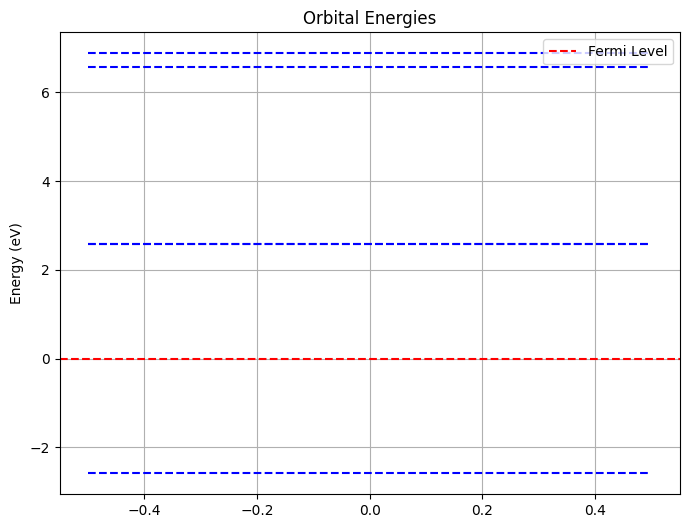

In [9]:
# Diagonalize the Hamiltonian and overlap matrices
eigenvalues, eigenvectors = eigh(H_subdiagonal, S_subdiagonal)

lumo_index = int(np.shape(H_subdiagonal)[0]/2)
homo_index = lumo_index - 1

# Calculate HOMO and LUMO energies, and gap
homo_energy, lumo_energy, homo_lumo_gap = calculate_homo_lumo(H_subdiagonal,S_subdiagonal,homo_index,lumo_index)

# Plot orbital energies around the Fermi level
plot_orbital_energies(H=H_subdiagonal, S=S_subdiagonal, fermi_level=0, n_valence=1, n_conduction=3)

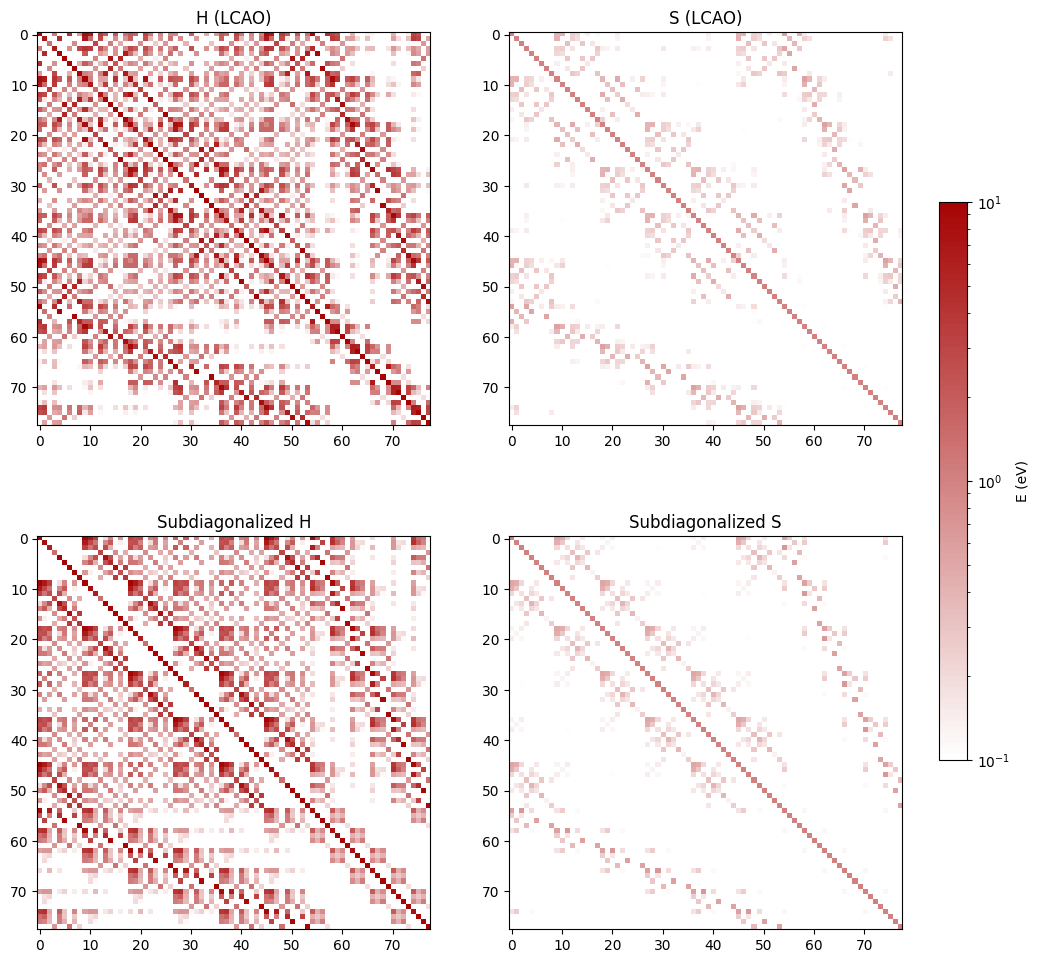

In [10]:
# Note that I'm plotting the absolute values in H and S for ease of visualization.

cmap_name = 'custom_white_red'
colors = [(1, 1, 1), (166/255, 4/255, 4/255)]
n_bins = 100
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = LogNorm(vmin=0.1, vmax=10)

# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot H_lcao in the first row, first column
cax1 = axs[0, 0].imshow(np.abs(H_lcao), interpolation='nearest', cmap=cm, norm=norm)
axs[0, 0].set_title("H (LCAO)")

# Plot S_lcao in the first row, second column
cax2 = axs[0, 1].imshow(np.abs(S_lcao), interpolation='nearest', cmap=cm, norm=norm)
axs[0, 1].set_title("S (LCAO)")

# Plot H_subdiagonal in the second row, first column
cax3 = axs[1, 0].imshow(np.abs(H_subdiagonal), interpolation='nearest', cmap=cm, norm=norm)
axs[1, 0].set_title("Subdiagonalized H")

# Plot S_subdiagonal in the second row, second column
cax4 = axs[1, 1].imshow(np.abs(S_subdiagonal), interpolation='nearest', cmap=cm, norm=norm)
axs[1, 1].set_title("Subdiagonalized S")

# Add a shared colorbar for all subplots
cbar = fig.colorbar(cax4, ax=axs, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_label('E (eV)')

plt.show()

In [11]:
# Define the active region within the subdiagonalized species (C 2 pz in this case)
active = {'C':[3]}
extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]

for idx in index_active_region:
    if Usub[idx-1,idx] < 0.: # change sign
        Usub[:,idx] *= -1

lowdin = False
if lowdin:
    Ulow = lowdin_rotation(H_subdiagonal, S_subdiagonal, index_active_region)

    H_subdiagonal = rotate_matrix(H_subdiagonal, Ulow)
    S_subdiagonal = rotate_matrix(S_subdiagonal, Ulow)

H_active, S_active = create_active_hamiltonian(H_subdiagonal, S_subdiagonal, index_active_region)

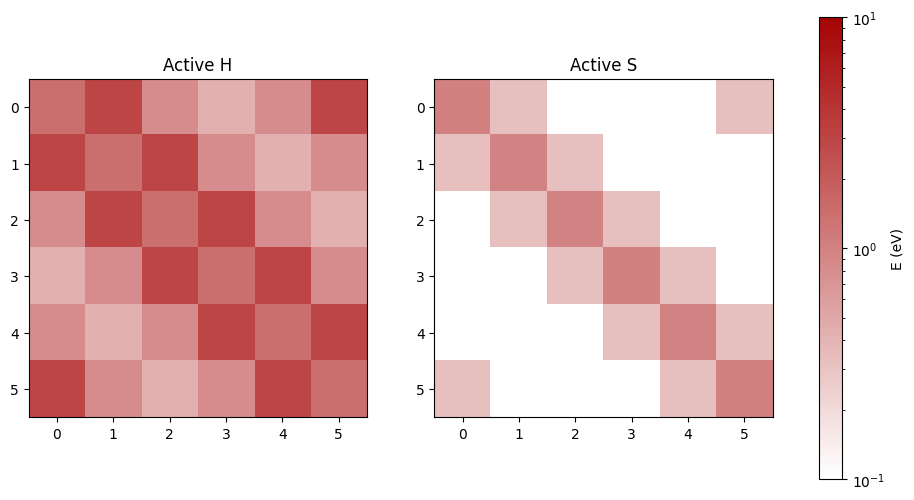

In [12]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subdiagonalized H matrix for the bridge region
cax1 = ax1.imshow(np.abs(H_active), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("Active H")

# Plot the subdiagonalized S matrix for the bridge region
cax2 = ax2.imshow(np.abs(S_active), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("Active S")

# Add a shared colorbar
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')

plt.show()


In [13]:
# Diagonalize the Hermitian Hamiltonian using eigh (eigenvalues are automatically sorted)
eigenvalues, eigenvectors = eigh(H_active, S_active)


lumo_index_active = int(np.shape(H_active)[0]/2)
homo_index_active = lumo_index_active - 1

homo_energy = eigenvalues[homo_index_active]
lumo_energy = eigenvalues[lumo_index_active]

# Calculate the HOMO-LUMO gap
homo_lumo_gap = lumo_energy - homo_energy

print(f"HOMO energy: {homo_energy} eV")
print(f"LUMO energy: {lumo_energy} eV")
print(f"HOMO-LUMO gap: {homo_lumo_gap} eV")

HOMO energy: -2.516516241897261 eV
LUMO energy: 3.0274452334385566 eV
HOMO-LUMO gap: 5.543961475335818 eV
